# Классификация видео с помощью 3D сверточной нейронной сети

Руководство по обучению 3D сверточной нейронной сети (CNN) для классификации видео с использованием набора данных для распознавания действий UCF101: (https://www.crcv.ucf.edu/data/UCF101.php). 3D CNN использует трехмерный фильтр для выполнения свертки. Ядро способно перемещаться в трех направлениях, тогда как в 2D CNN оно может перемещаться в двух измерениях. Модель основана на работе, опубликованной в работе "Более пристальный взгляд на пространственно-временные свертки для распознавания действий" (https://arxiv.org/abs/1711.11248v3).

1) Построение входного конвейера
2) Постройте 3D-модель сверточной нейронной сети с остаточными связями, используя Keras functional API
3) Обучаем модель
4) Оцените и протестируйте модель

Другие руководства:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): моделями MoViNet, доступные на TF Hub
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): руководство о том, как использовать предварительно обученную модель классификации видео, обученную на другом наборе данных с набором данных UCF-101.

## Импорт библиотек

In [30]:
import sys
import os
import pathlib
import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random
import collections

import cv2
import einops # для тензонрых преобразоаний
import imageio
import remotezip as rz

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_docs.vis import embed

In [16]:
sys.path.append('D:/Programming/Python')

In [17]:
from ml_tools import training_plot

## Загруска исходного датасета

Вспомогательные функции для загрузки фрагмента данных из набора данных UCF-101 и загрузки его в tf.data.Dataset. 

Более подробно смотри тут: [Учебное руководство по загрузке видеоданных](../load_data/video.ipynb).

Класс FrameGenerator создает итерируемый объект, который может передавать данные в конвейер данных TensorFlow. В частности, этот класс содержит генератор Python, который загружает видеокадры вместе с их закодированной меткой. Функция генератора (`__call__`) возвращает массив кадров, созданный с помощью `frames_from_video_file`, и вектор метки, закодированный в горячем виде, связанный с набором кадров.

In [18]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

Проверка содержимого zip-файла по этому URL-адресу

In [19]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [20]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

Извлечение имяни класса из имени файла

In [21]:
def get_class(fname):
  return fname.split('_')[-3]

Преобразование списка всех файлов в словарь со списком файлов для каждого класса

In [22]:
def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [23]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


Разделение видео на обучающие, проверочные и тестовые наборы. Видео загружаются по URL-адресу с zip-файлом и помещаются в соответствующие подкаталоги.

In [24]:
def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

Функция, которая возвращает оставшиеся данные, которые еще не были помещены в подмножество данных. 
Это позволяет вам поместить эти оставшиеся данные в следующее указанное подмножество данных.

In [25]:
def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

Загрузка подмножества набора данных UCF101 и разделение его на обучающий, проверочный и тестовый наборы. 
Можно указать количество классов, которые вы хотели бы использовать. 
Аргумент splits позволяет вам передать словарь, в котором ключевыми значениями являются название подмножества (пример: "train") и количество видео, которые вы хотели бы иметь в каждом классе.

In [26]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
    
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [27]:
def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [29]:
download_dir = os.path.abspath('./UCF101_subset/')
download_dir

'd:\\Programming\\projects\\ML\\videos\\classification\\video_classification\\UCF101_subset'

In [32]:
download_dir = pathlib.Path('./UCF101_subset/')
download_dir

WindowsPath('UCF101_subset')

In [33]:
download_dir = os.path.abspath('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir=download_dir)

train :


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


`frames_from_video_file` Функция разбивает видео на кадры, считывает случайно выбранный интервал n_frames из видеофайла и возвращает их в виде NumPy array. 
Чтобы сократить объем памяти и вычислительные издержки, выбирайте небольшое количество кадров. 
Кроме того, выберите одинаковое количество кадров из каждого видео, что упрощает работу с пакетами данных.

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224, 224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

## Визуализация данных

In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


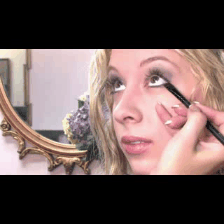

In [ ]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

Класс, который может передавать данные в конвейер данных TensorFlow. 
Функция generator (__call__) выдает массив кадров, созданный с помощью frames_from_video_file, и вектор метки в однократном кодировании, связанный с набором кадров.

In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 4


## Импорт исходного датасета

In [ ]:
os.listdir()

['videos',
 'video_classification.ipynb',
 '.git',
 '.gitignore',
 'UCF101_subset',
 'animation.gif']

Конвейер ввода данных TensorFlow. 
Этот конвейер, который вы создаете на основе объекта generator, позволяет вам вводить данные в вашу модель глубокого обучения. 
В этом видеопотоке каждый элемент представляет собой отдельный набор кадров и связанную с ним метку.

In [ ]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

In [ ]:
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)

Убедитесь, что метки перемешаны.

In [ ]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)


## Разделение данных

In [ ]:
# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

In [ ]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (8, 10, 224, 224, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 10, 224, 224, 3)
Shape of validation labels: (8,)


## Создание модели

The following 3D convolutional neural network model is based off the paper [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017). The paper compares several versions of 3D ResNets. Instead of operating on a single image with dimensions `(height, width)`, like standard ResNets, these operate on video volume `(time, height, width)`. The most obvious approach to this problem would be replace each 2D convolution (`layers.Conv2D`) with a 3D convolution (`layers.Conv3D`).

This tutorial uses a (2 + 1)D convolution with [residual connections](https://arxiv.org/abs/1512.03385). The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters. 

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [ ]:
# Define the dimensions of one frame in the set of frames created
WIDTH, HEIGHT = 224, 224

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [ ]:
frames, label = next(iter(train_ds))
model.build(frames)

## Обучение модели

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Train the model for 50 epoches with the Keras `Model.fit` method.

Note: This example model is trained on fewer data points (300 training and 100 validation examples) to keep training time reasonable for this tutorial. Moreover, this example model may take over one hour to train.

In [ ]:
history = model.fit(x = train_ds,
                    epochs = 5, # 50
                    validation_data = val_ds)

Epoch 1/5
     38/Unknown 9s 9s/step - accuracy: 0.0000e+00 - loss: 3.2511s 2s/step - accuracy: 0.0312 - loss: 3.1349  14s 2s/step - accuracy: 0.0625 - loss: 3.04616s 2s/step - accuracy: 0.0859 - loss: 2.97718s 2s/step - accuracy: 0.0938 - loss: 2.97020s 2s/step - accuracy: 0.0990 - loss: 2.96122s 2s/step - accuracy: 0.1001 - loss: 2.95624s 2s/step - accuracy: 0.0993 - loss: 2.95926s 2s/step - accuracy: 0.0976 - loss: 2.96329s 2s/step - accuracy: 0.0953 - loss: 2.96331s 2s/step - accuracy: 0.0928 - loss: 2.96233s 2s/step - accuracy: 0.0920 - loss: 2.95735s 2s/step - accuracy: 0.0909 - loss: 2.95237s 2s/step - accuracy: 0.0901 - loss: 2.94639s 2s/step - accuracy: 0.0891 - loss: 2.93841s 2s/step - accuracy: 0.0879 - loss: 2.92943s 2s/step - accuracy: 0.0875 - loss: 2.91946s 2s/step - accuracy: 0.0869 - loss: 2.90848s 2s/step - accuracy: 0.0861 - loss: 2.89850s 2s/step - accuracy: 0.0856 - loss: 2.88952s 2s/step - accuracy: 0.0852 - loss: 2.88054s 2s/step - accuracy: 0.0847 - loss: 2.8725

c:\Python\Python 3.11.8\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


38/38 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.0927 - loss: 2.7443 - val_accuracy: 0.1100 - val_loss: 2.4070
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - accuracy: 0.3750 - loss: 1.910 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.2812 - loss: 2.248 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.2431 - loss: 2.330 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.2135 - loss: 2.363 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.2108 - loss: 2.371 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.2174 - loss: 2.358 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.2220 - loss: 2.350 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.2236 - loss: 2.346 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.2311 - loss: 2.336 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.2355 - loss: 2.329 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.2399 - loss: 2.319 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2434 - loss: 2.309 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2454 - loss: 2.30 ━

### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

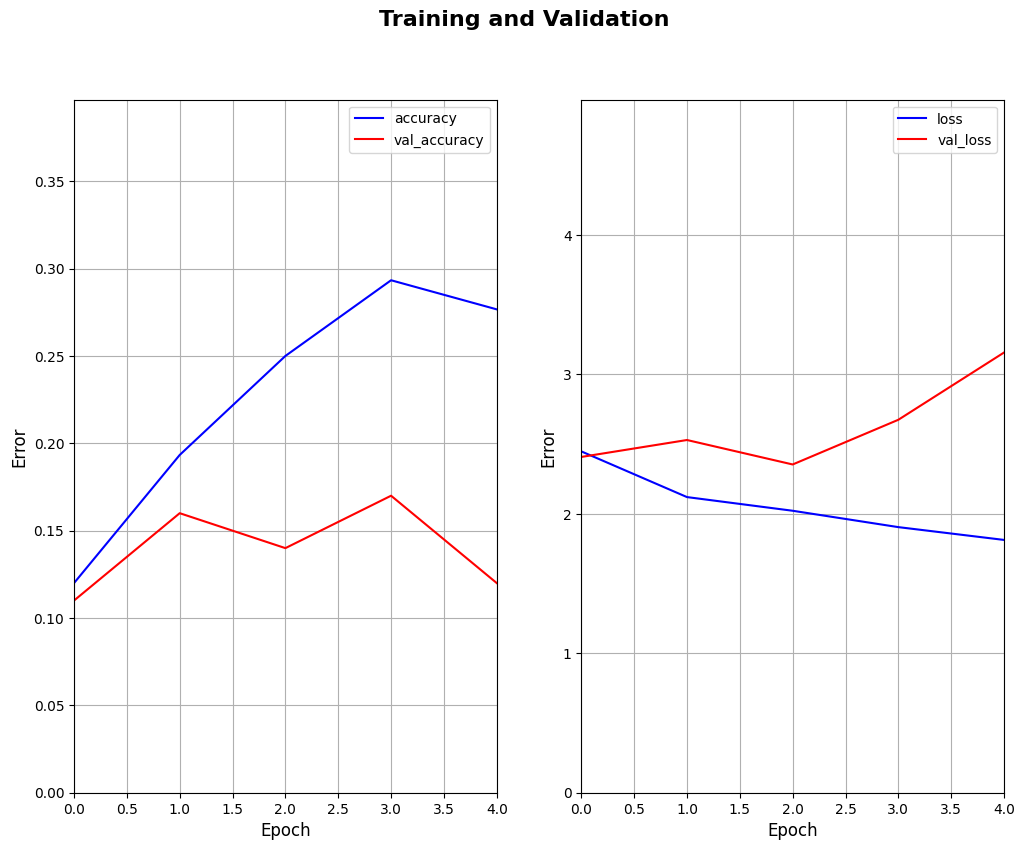

In [ ]:
training_plot(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset. 

Note: The example model in this tutorial uses a subset of the UCF101 dataset to keep training time reasonable. The accuracy and loss can be improved with further hyperparameter tuning or more training data. 

In [ ]:
model.evaluate(test_ds, return_dict=True)

13/1313/Unknown 1s 1s/step - accuracy: 1.0000 - loss: 0.512s 917ms/step - accuracy: 0.8125 - loss: 0.6733s 926ms/step - accuracy: 0.6806 - loss: 1.0024s 916ms/step - accuracy: 0.5885 - loss: 1.3115s 930ms/step - accuracy: 0.5208 - loss: 1.4856s 950ms/step - accuracy: 0.4722 - loss: 1.6127s 981ms/step - accuracy: 0.4354 - loss: 1.7498s 992ms/step - accuracy: 0.4044 - loss: 1.8819s 999ms/step - accuracy: 0.3780 - loss: 1.99710s 993ms/step - accuracy: 0.3552 - loss: 2.0811s 1s/step - accuracy: 0.3353 - loss: 2.1704  12s 1s/step - accuracy: 0.3178 - loss: 2.24813s 967ms/step - accuracy: 0.3025 - loss: 2.32 ━━━━━━━━━━━━━━━━━━━━ 13s 969ms/step - accuracy: 0.2895 - loss: 2.3709


{'accuracy': 0.11999999731779099, 'loss': 2.9916954040527344}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [ ]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

KeyboardInterrupt: 

     13/Unknown 1s 1s/st2s 958ms/ste3s 996ms/ste4s 984ms/ste5s 986ms/ste6s 980ms/ste7s 993ms/ste8s 986ms/ste9s 965ms/ste10s 946ms/st10s 943ms/st11s 938ms/st12s 891ms/step

c:\Python\Python 3.11.8\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 891ms/step


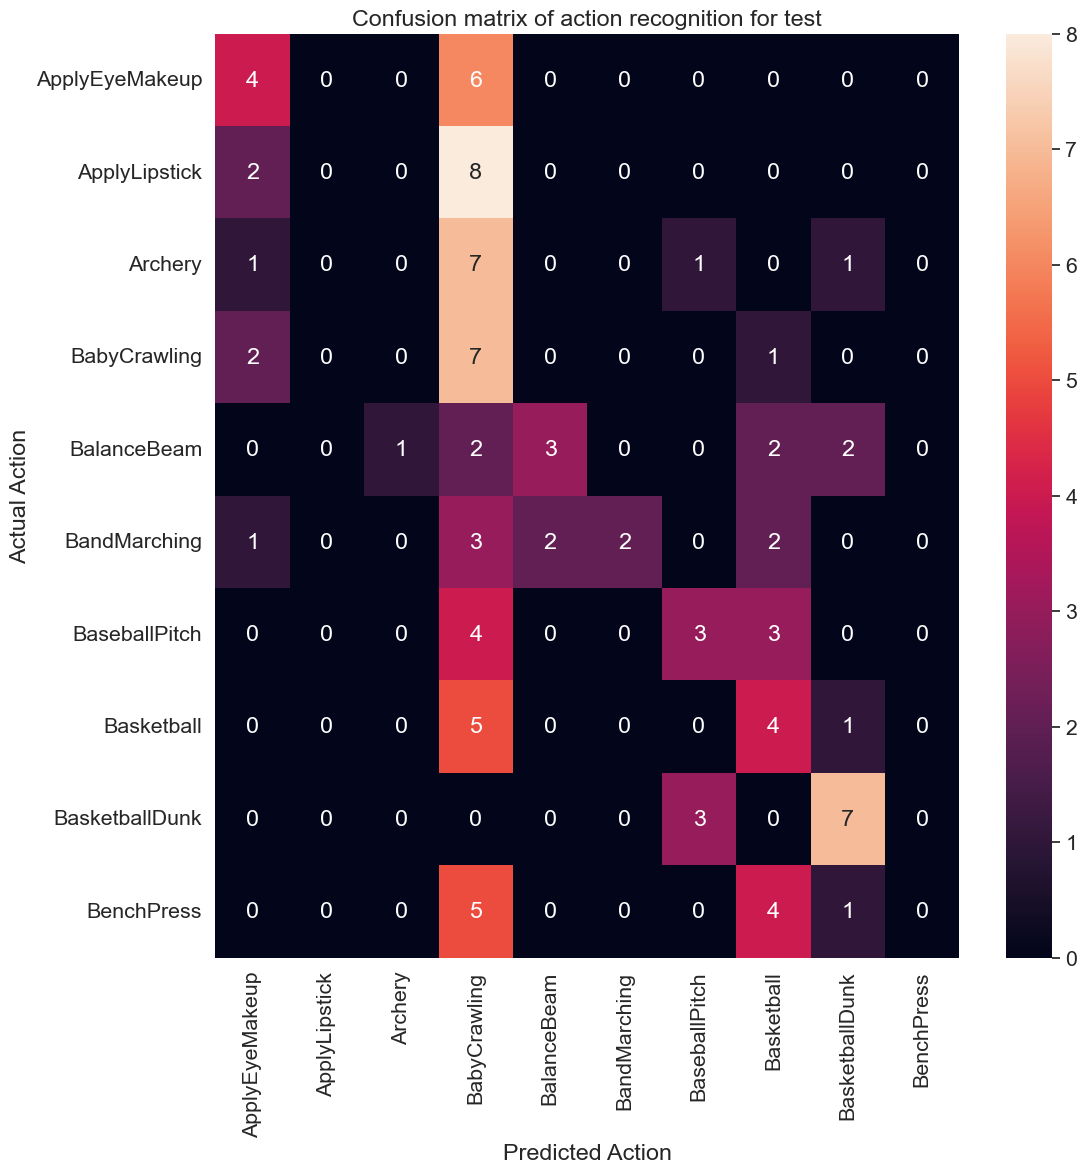

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

C:\Users\parkh\AppData\Local\Temp\ipykernel_39136\791028922.py:25: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision


In [ ]:
precision

{'ApplyEyeMakeup': 0.4,
 'ApplyLipstick': nan,
 'Archery': 0.0,
 'BabyCrawling': 0.14893617021276595,
 'BalanceBeam': 0.6,
 'BandMarching': 1.0,
 'BaseballPitch': 0.42857142857142855,
 'Basketball': 0.25,
 'BasketballDunk': 0.5833333333333334,
 'BenchPress': nan}

In [ ]:
recall

{'ApplyEyeMakeup': 0.4,
 'ApplyLipstick': 0.0,
 'Archery': 0.0,
 'BabyCrawling': 0.7,
 'BalanceBeam': 0.3,
 'BandMarching': 0.2,
 'BaseballPitch': 0.3,
 'Basketball': 0.4,
 'BasketballDunk': 0.7,
 'BenchPress': 0.0}

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)